<!---
The MIT License (MIT)

Copyright (c) 2017 Sean UN Wood

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
--->

# Low-latency Speech Enhancement with GCC-NMF:
## iPython Notebook Demo

#### Sean UN Wood, August 2017

This iPython Notebook is a demonstration of the algorithm presented in:

- Sean UN Wood and Jean Rouat, [*Towards GCC-NMF Speech Enhancement for Hearing Assistive Devices: Reducing Latency with Asymmetric Windows*](), **International Workshop on Challenges in Hearing Assistive Technology** (CHAT) 2017.

that builds on previous work:
 - Sean UN Wood and Jean Rouat, [*Real-time Speech Enhancement with GCC-NMF*](https://www.researchgate.net/publication/318511757_Real-time_Speech_Enhancement_with_GCC-NMF), **Interspeech 2017**.

## Abstract

This demo builds on the real-time GCC-NMF speech enhancement [iPython notebook](), where we enhance the noisy speech signal found at *data/dev_Sq1_Co_A_mix.wav*, taken from the SiSEC 2016 [Two-channel Mixtures of Speech and Real-world Background Noise](https://sisec.inria.fr/sisec-2015/2015-two-channel-mixtures-of-speech-and-real-world-background-noise/) "dev" dataset. We extend real-time GCC-NMF here with the asymmetric STFT windowing strategy, maintaining the long analysis windows required by GCC-NMF, but using short synthesis windows, drastically reducing the algorithmic latency. We demonstrate that the asymmetric STFT windowing strategy results in similar speech enhancement results to the traditional symmetric STFT windowing case. The asymmetric windowing strategy we use was proposed in,

- D. Mauler and R. Martin, [*A low delay, variable resolution, perfect reconstruction spectral analysis-synthesis system for speech enhancement*]() in Signal Processing Conference, 2007 15th European. IEEE, 2007, pp. 222–226.

## Notebook Overview

The first three sections, listed in italics, are repeated from the [*real-time GCC-NMF notebook*]().

1. *Preliminary setup*
2. *Load input mixture signal*
3. *NMF dictionary pre-learning*
4. Construct analysis and synthesis windows
5. Perform speech enhancement frame-by-frame using:
  - Traditional symmetric windowing
  - Proposed asymmetric windowing
6. Study frame size 

# 1. Preliminary setup
#### Python imports

In [1]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *

from numpy import *
from numpy.fft import rfft, irfft
from matplotlib.pylab import cm
from matplotlib import gridspec

from IPython import display

%matplotlib inline

#### Parameter definitions

In [2]:
# Preprocessing params
fftSize = 1024

# Asymmetric windowing params
analysisWindowSize = fftSize
synthesisWindowSize = 128
asymmetricHopSize = (synthesisWindowSize * 3) // 4
m = synthesisWindowSize // 2
k = analysisWindowSize
d = 0

# Symmetric windowing params
symmetricWindowSize = fftSize
#symmetricHopSize = (fftSize * 3) // 4
symmetricHopSize = asymmetricHopSize # to better compare results

# TDOA params
numTDOAs = 128
targetTDOAEpsilonPercent = 0.05 # controls the TDOA width for GCC-NMF mask generation
targetTDOAEpsilon = targetTDOAEpsilonPercent * numTDOAs

# NMF params
trainingDataFileName = '../data/chimeTrainSet.npy'
dictionarySize = 128
numPreLearningIterations = 100
numInferenceIterations = 0
sparsityAlpha = 0
epsilon = 1e-16
seedValue = 0

# Input params    
mixtureFileNamePrefix = '../data/dev_Sq1_Co_A'
microphoneSeparationInMetres = 0.086

# 2. Input mixture signal

#### Load noisy speech signal from the wav file

In [3]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

display.display( display.Audio(mixtureFileName) )

#### Plot noisy speech signal

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


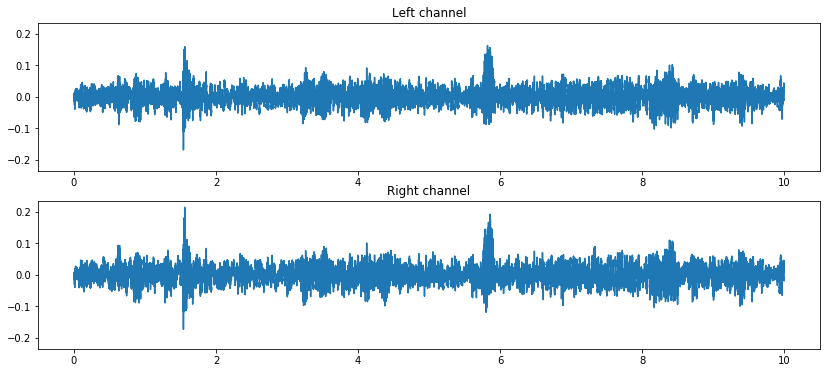

In [4]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

# 3. NMF Dictionary Pre-learning

Pre-learn the NMF dictionary from a small subset of the [CHiME dataset](http://spandh.dcs.shef.ac.uk/chime_challenge/). A total of 1024 FFT frames are loaded divided equally between isolated speech and noise signals.

#### Load CHiME training data

In [5]:
trainV = load(trainingDataFileName)
numFrequencies, numTrainFrames = trainV.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

#### Plot CHiME training data

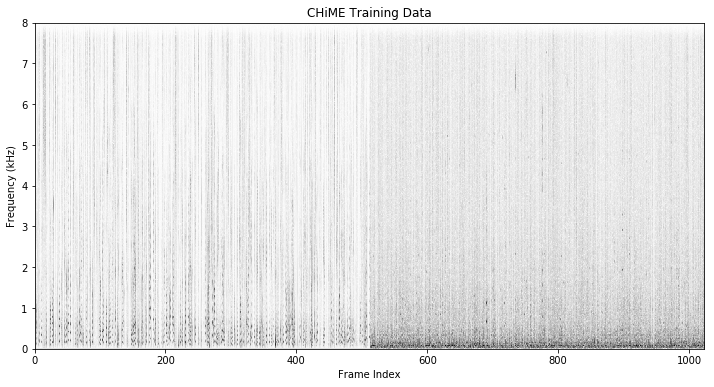

In [6]:
figure(figsize=(12, 6))
imshow((trainV / max(trainV)) ** (1/3.0),
        extent=[0, trainV.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('CHiME Training Data')
ylabel('Frequency (kHz)')
xlabel('Frame Index')
show()

#### Learn NMF dictionary

In [7]:
W, H = performKLNMF(trainV, dictionarySize, numPreLearningIterations,
                    sparsityAlpha, epsilon, seedValue)

#### Plot NMF dictionary

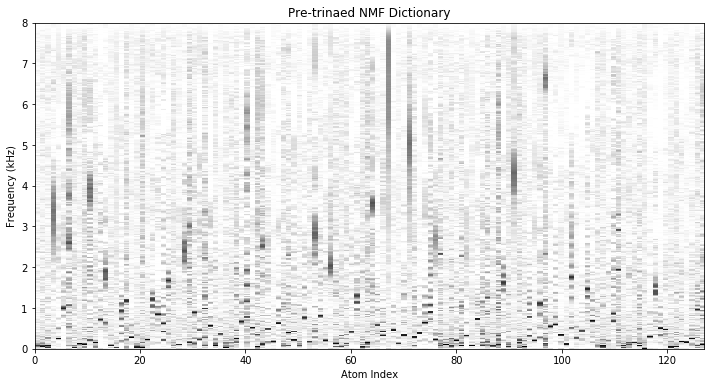

In [8]:
figure(figsize=(12, 6))
imshow((W / max(W)) ** (1/3.0),
        extent=[0, W.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('Pre-trinaed NMF Dictionary')
ylabel('Frequency (kHz)')
xlabel('Atom Index')
show()

# 4. Analysis and Synthesis Windows

#### Define Analysis and Synthesis Window Functions:

In [9]:
def getAsymmetricAnalysisWindow(k, m, d):
    risingSqrtHann = sqrt( hanning(2*(k-m-d)+1)[:2*(k-m-d)] )
    fallingSqrtHann = sqrt( hanning(2*m+1)[:2*m] )
    
    window = zeros(k)
    window[:d] = 0
    window[d:k-m] = risingSqrtHann[:k-m-d]
    window[k-m:] = fallingSqrtHann[-m:]
    
    return window

def getAsymmetricSynthesisWindow(k, m, d):
    risingSqrtHannAnalysis = sqrt( hanning(2*(k-m-d)+1)[:2*(k-m-d)] )
    risingNoramlizedHann = hanning(2*m+1)[:m] / risingSqrtHannAnalysis[k-2*m-d:k-m-d]
    fallingSqrtHann = sqrt( hanning(2*m+1)[:2*m] )
    
    window = zeros(k)
    window[:-2*m] = 0
    window[-2*m:-m] = risingNoramlizedHann
    window[-m:] = fallingSqrtHann[-m:]
    
    return window

#### Construct Windows:

In [10]:
analysisWindow = getAsymmetricAnalysisWindow(k, m, d)
synthesisWindow = getAsymmetricSynthesisWindow(k, m, d)

symmetricWindow = sqrt(hanning(symmetricWindowSize))

#### Compare with Traditional Symmetric Windowing:

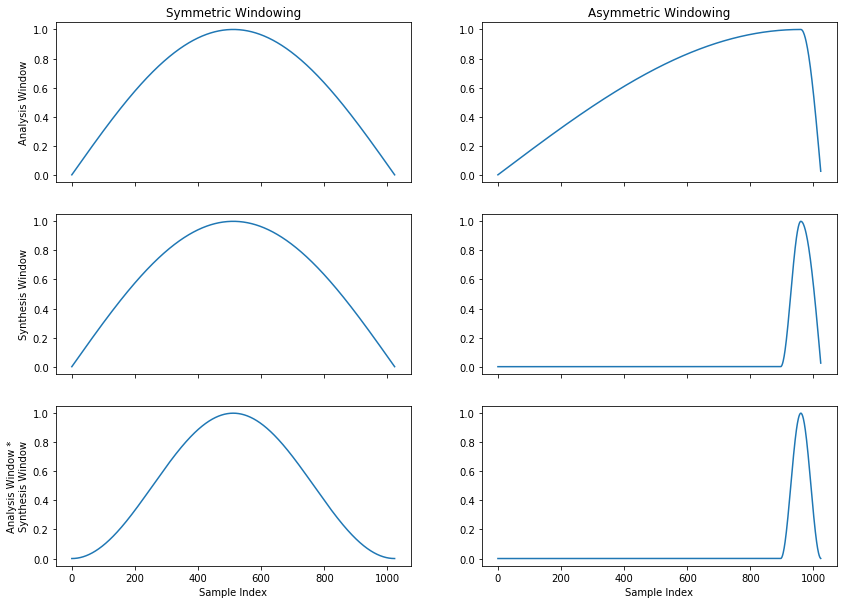

In [11]:
figure(figsize=(14, 10))

ax = subplot(321)
plot(symmetricWindow)
ax.set_xticklabels([])
ylabel('Analysis Window')
title('Symmetric Windowing')
ax = subplot(323)
plot(symmetricWindow)
ax.set_xticklabels([])
ylabel('Synthesis Window')
ax = subplot(325)
plot(symmetricWindow * symmetricWindow)
xlabel('Sample Index')
ylabel('Analysis Window *\nSynthesis Window')

ax = subplot(322)
plot(analysisWindow)
ax.set_xticklabels([])
title('Asymmetric Windowing')
ax = subplot(324)
ax.set_xticklabels([])
plot(synthesisWindow)
ax = subplot(326)
plot(analysisWindow * synthesisWindow)
xlabel('Sample Index')

show()

# 5. Online Speech Enhancement

#### Define variables used online:

In [12]:
tdoasInSeconds = getTDOAsInSeconds(microphoneSeparationInMetres, numTDOAs)
expJOmegaTau = exp( outer(frequenciesInHz, -(2j * pi) * tdoasInSeconds) )

#### Define online speech enhancement function:

In [13]:
def performOnlineSpeechEnhancement(analysisWindow, synthesisWindow, hopSize):
    # Setup variables to save speech enhancement results
    numFrames = (numSamples-len(synthesisWindow)) // hopSize
    gainFactor = hopSize / len(synthesisWindow) * 2

    targetEstimateSamplesOLA = zeros_like(stereoSamples)
    gccPHATAccumulatedMax = zeros(numTDOAs)
    gccPHATAccumulatedMax[:] = -inf
    atomMask = zeros(dictionarySize)
    targetTDOAs = zeros(numFrames)
    targetTDOAs[:] = nan

    angularSpectrogram = zeros( (numTDOAs, numFrames) )
    atomMasks = zeros( (dictionarySize, numFrames) )
    wienerFilters = zeros( (2, numFrequencies, numFrames) )
    inputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')
    outputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')

    # For each STFT frame:
    # 1. Compute FFT
    # 2. Localize target with accumulated GCC-PHAT localization
    # 3. Compute GCC-NMF atom mask
    # 4. Construct Wiener-like filter, and filter input
    # 5. Reconstruct time domain samples
    # 6. Overlap-add to output samples
    
    for frameIndex in range(numFrames):
        # Compute FFT
        frameStart = frameIndex * hopSize
        frameEnd = frameStart + analysisWindowSize
        stereoSTFTFrame = rfft( stereoSamples[:, frameStart:frameEnd] * analysisWindow )
        inputSpectrogram[..., frameIndex] = stereoSTFTFrame

        # localize target with accumulated GCC-PHAT
        coherenceV = stereoSTFTFrame[0] * stereoSTFTFrame[1].conj() / abs(stereoSTFTFrame[0]) / abs(stereoSTFTFrame[1])
        gccPHAT = dot(coherenceV, expJOmegaTau).real
        gccPHATAccumulatedMax = max( array( [gccPHAT, gccPHATAccumulatedMax] ), axis=0 )
        targetTDOAEstimate = argmax(gccPHATAccumulatedMax)
        targetTDOAs[frameIndex] = targetTDOAEstimate
        angularSpectrogram[:, frameIndex] = gccPHAT

        # compute GCC-NMF atom mask
        gccNMF = dot( (coherenceV[:, newaxis] * expJOmegaTau).real.T, W )
        gccNMFTDOAEstimates = argmax(gccNMF, axis=0)
        atomMask[:] = 0
        atomMask[ abs(gccNMFTDOAEstimates - targetTDOAEstimate) < targetTDOAEpsilon ] = 1
        atomMasks[:, frameIndex] = atomMask

        # construct wiener filter
        if numInferenceIterations == 0:
            wienerFilter = sum(atomMask * W, axis=1) / sum(W, axis=1)
            wienerFilters[:, :, frameIndex] = wienerFilter
        else:
            stereoH = inferCoefficientsKLNMF( abs(stereoSTFTFrame).T, W, numInferenceIterations,
                                              sparsityAlpha, epsilon, seedValue)
            recV = dot(W, stereoH)
            sourceEstimate = dot(W, stereoH * atomMask[:, newaxis])
            wienerFilter = (sourceEstimate / recV).T
            wienerFilters[:, :, frameIndex] = wienerFilter

        filterdSTFTFrame = wienerFilter * stereoSTFTFrame
        outputSpectrogram[..., frameIndex] = filterdSTFTFrame

        # reconstruct time domain samples
        recStereoSTFTFrame = irfft(filterdSTFTFrame)

        # overlap-add to output samples
        targetEstimateSamplesOLA[:, frameStart:frameEnd] += recStereoSTFTFrame

    targetEstimateSamplesOLA *= gainFactor
        
    return inputSpectrogram, outputSpectrogram, targetEstimateSamplesOLA, \
           gccPHATAccumulatedMax, targetTDOAs, angularSpectrogram, atomMasks, wienerFilters

#### Define function to plot results (left channel only for clarity):

In [14]:
def plotResults(titleString, mainGridSpec, inputSpectrogram, outputSpectrogram, targetEstimateSamplesOLA, \
                gccPHATAccumulatedMax, targetTDOAs, angularSpectrogram, atomMasks, wienerFilters):
    gridSpec = gridspec.GridSpecFromSubplotSpec(5, 1, mainGridSpec)
    ax = subplot(gridSpec[0])
    imshow(angularSpectrogram, cmap=cm.jet,
           extent=[0, angularSpectrogram.shape[1]-1, tdoasInSeconds[0]*1000.0, tdoasInSeconds[-1]*1000.0])
    targetTDOAsInMilliSeconds = take(tdoasInSeconds, targetTDOAs.astype('int32')) * 1000.0
    plot( targetTDOAsInMilliSeconds, 'r')
    ylabel('TDOA (ms)')
    title(titleString)
    
    ax = subplot(gridSpec[1])
    imshow( atomMasks, cmap=cm.binary )
    ylabel('Atom Index')
    
    ax = subplot(gridSpec[2])
    imshow( wienerFilters[0], cmap=cm.jet,
            extent=[0, wienerFilters.shape[-1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]] )
    ylabel('Frequency (kHz)')
                    
    ax = subplot(gridSpec[3])
    imshow( abs(outputSpectrogram[0]) ** (1/3.0), cmap=cm.jet,
            extent=[0, outputSpectrogram.shape[-1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]] )
    ylabel('Frequency (kHz)')
    
    ax = subplot(gridSpec[4])
    plot(targetEstimateSamplesOLA[0])
    xlim( (0, targetEstimateSamplesOLA.shape[-1]-1) )
    xlabel('Time (samples)')

#### Perform speech enhancement frame by frame using asymmetric and symmetric windowing:

In [15]:
symmetricResults = performOnlineSpeechEnhancement(symmetricWindow, symmetricWindow, symmetricHopSize)
asymmetricResults = performOnlineSpeechEnhancement(analysisWindow, synthesisWindow, asymmetricHopSize)

#### Compare asymmetric and symmetric windowing results:

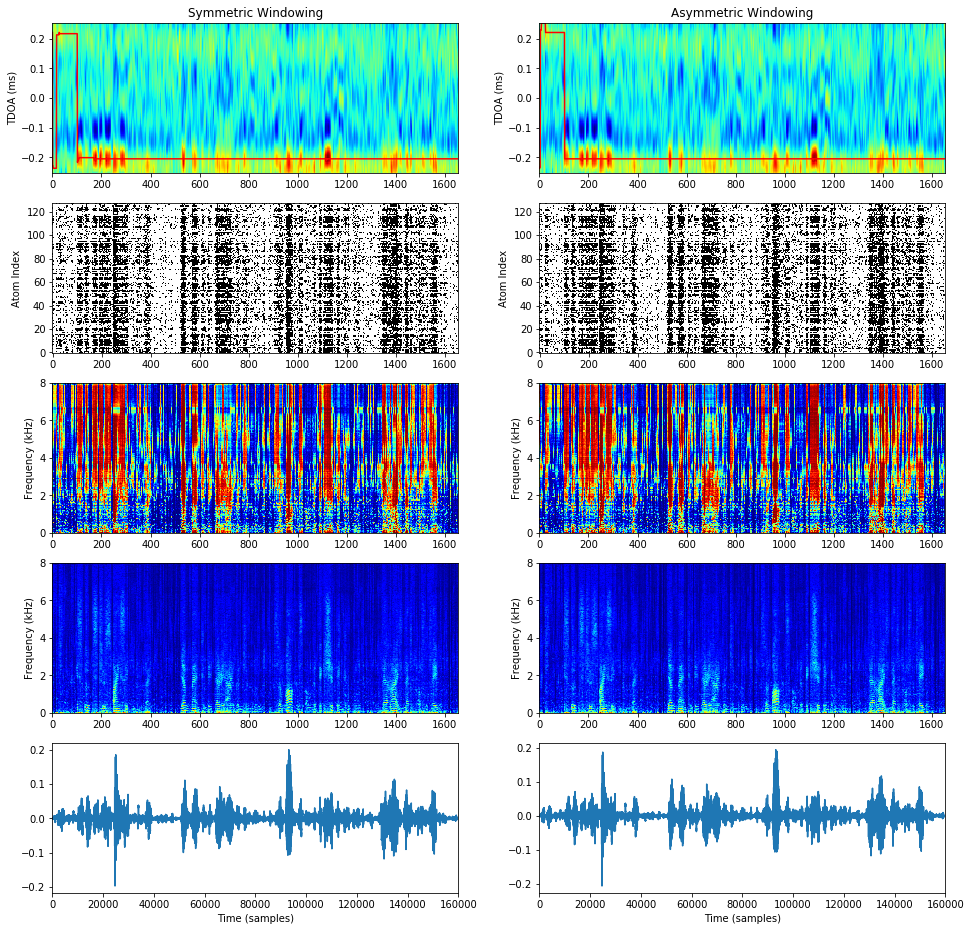

In [16]:
figure(figsize=(16, 16))
mainGridSpec = gridspec.GridSpec(1, 2)
plotResults( 'Symmetric Windowing', mainGridSpec[0], *symmetricResults)
plotResults( 'Asymmetric Windowing', mainGridSpec[1], *asymmetricResults )
show()

#### Plot input, symmetric windowing output, asymmetric windowing output:

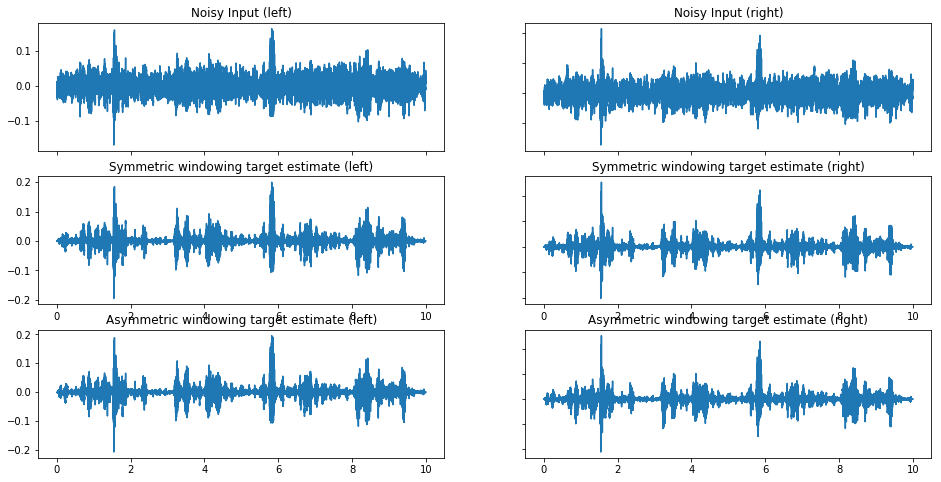

In [17]:
figure(figsize=(16, 8))

sampleTimesInSeconds = arange(numSamples) / float(sampleRate)

ax = subplot(321)
plot(sampleTimesInSeconds, stereoSamples[0])
ax.set_xticklabels([])
title('Noisy Input (left)')

ax = subplot(322)
plot(sampleTimesInSeconds, stereoSamples[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
title('Noisy Input (right)')

ax = subplot(323)
plot(sampleTimesInSeconds, symmetricResults[2][0])
title('Symmetric windowing target estimate (left)')

ax = subplot(324)
plot(sampleTimesInSeconds, symmetricResults[2][1])
ax.set_yticklabels([])
title('Symmetric windowing target estimate (right)')

ax = subplot(325)
plot(sampleTimesInSeconds, asymmetricResults[2][0])
title('Asymmetric windowing target estimate (left)')

ax = subplot(326)
plot(sampleTimesInSeconds, asymmetricResults[2][1])
ax.set_yticklabels([])
title('Asymmetric windowing target estimate (right)')

show()

#### Input / output audio playback:

In [18]:
symmetricTargetEstimateFileName = mixtureFileNamePrefix + '_sim_symmetric.wav'
wavfile.write( symmetricTargetEstimateFileName, sampleRate, symmetricResults[2].T )

asymmetricTargetEstimateFileName = mixtureFileNamePrefix + '_sim_asymmetric.wav'
wavfile.write( asymmetricTargetEstimateFileName, sampleRate, asymmetricResults[2].T )

print('Noisy Mixture:')
display.display(display.Audio(mixtureFileName))

print('Symmetric Target Estimate:')
display.display(display.Audio(symmetricTargetEstimateFileName))

print('Asymmetric Target Estimate:')
display.display(display.Audio(asymmetricTargetEstimateFileName))

Noisy Mixture:


Symmetric Target Estimate:


Asymmetric Target Estimate:
